## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import matplotlib.gridspec as gridspec
from tqdm import tqdm


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256, momentum=0),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64, momentum=0),
            nn.Linear(64, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
         LeakyReLU-3                  [-1, 256]               0
       BatchNorm1d-4                  [-1, 256]             512
            Linear-5                   [-1, 64]          16,448
         LeakyReLU-6                   [-1, 64]               0
       BatchNorm1d-7                   [-1, 64]             128
            Linear-8                   [-1, 10]             650
        LogSoftmax-9                   [-1, 10]               0
Total params: 218,698
Trainable params: 218,698
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.83
Estimated Total Size (MB): 0.85
-------------------------------------------

Your experiments come here:

In [12]:
model = TinyNeuralNetwork()
opt = torch.optim.Adam(model.parameters(), lr=3e-3, betas=(0.7, 0.9))
loss_func = nn.NLLLoss()

# Your experiments, come here
def accuracy(model):
    total = 0
    for x, y in test_loader:
        total += torch.sum(model.forward(x).argmax(axis=1) == y)
    return total / len(fmnist_dataset_test)

n_epoch = 100

losses = []
model.train(True)
for i in tqdm(range(n_epoch)):
    # Test loss calculation
    current_loss = 0
    for img, label in train_loader:
        # Forward
        predictions = model.forward(img)
        loss = loss_func(predictions, label)
        current_loss += loss.item()

        # Backward
        loss.backward()

        # Update weights
        opt.step()
        opt.zero_grad()
    losses.append(current_loss)

100%|█████████████████████████████████████████| 100/100 [13:32<00:00,  8.12s/it]


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [13]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256, momentum=0),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256, momentum=0),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [14]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
         LeakyReLU-3                  [-1, 256]               0
       BatchNorm1d-4                  [-1, 256]             512
            Linear-5                  [-1, 256]          65,792
         LeakyReLU-6                  [-1, 256]               0
       BatchNorm1d-7                  [-1, 256]             512
            Linear-8                   [-1, 10]           2,570
        LogSoftmax-9                   [-1, 10]               0
Total params: 270,346
Trainable params: 270,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.03
Estimated Total Size (MB): 1.05
-------------------------------------------

In [15]:
model = OverfittingNeuralNetwork().to(device)
model = OverfittingNeuralNetwork()
opt = torch.optim.Adam(model.parameters(), lr=3e-3, betas=(0.7, 0.9))
loss_func = nn.NLLLoss()

# Your experiments, come here
n_epoch = 400

losses = []
accuracies = []
for i in tqdm(range(n_epoch)):
    # Test loss calculation
    current_loss = 0
    model.train(True)
    for img, label in train_loader:
        # Forward
        predictions = model.forward(img)
        loss = loss_func(predictions, label)
        current_loss += loss.item()

        # Backward
        loss.backward()

        # Update weights
        opt.step()
        opt.zero_grad()
    losses.append(current_loss)
    model.train(False)
    accuracies.append(accuracy(model))

100%|█████████████████████████████████████████| 400/400 [57:32<00:00,  8.63s/it]


loss: tensor(0.3010, grad_fn=<NllLossBackward0>)
accuracy: tensor(0.8582)


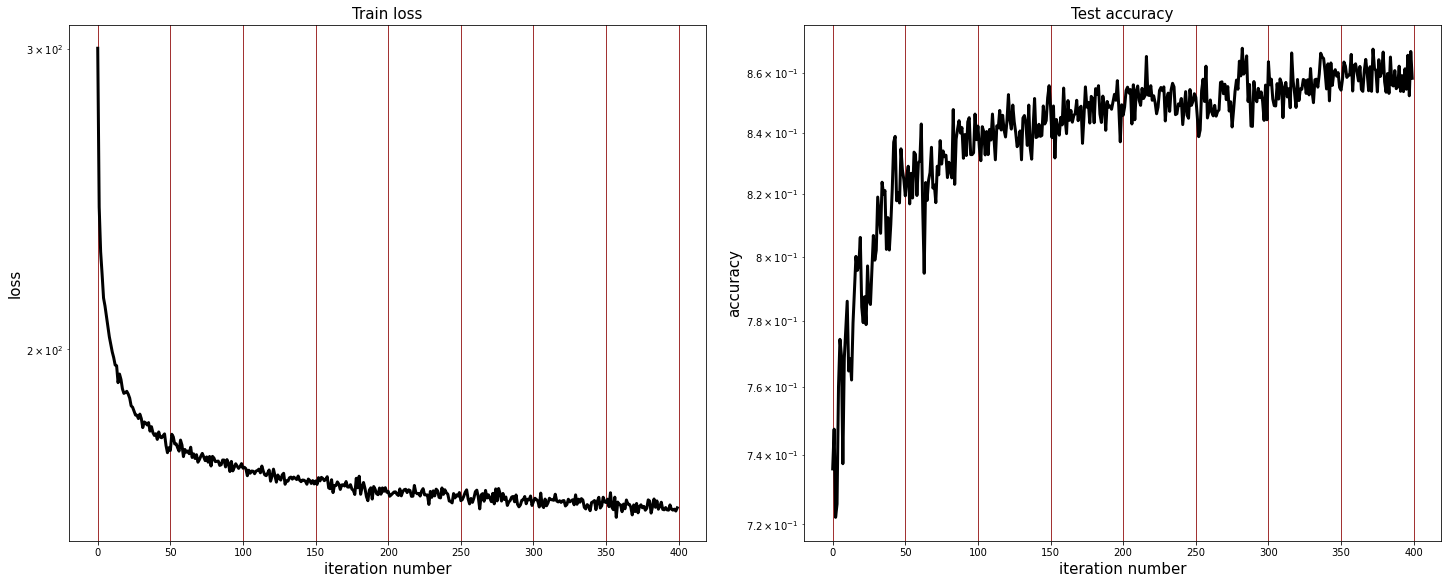

In [23]:
fg = plt.figure(figsize=(20, 8), constrained_layout=True, facecolor = "white")
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)

fig_ax_1 = fg.add_subplot(gs[0, 0], facecolor = "white")
fig_ax_1.semilogy(losses, 'black', linewidth=3)
fig_ax_1.set_xlabel("iteration number", fontsize=15)
fig_ax_1.set_ylabel("loss", fontsize=15)
fig_ax_1.set_title("Train loss", fontsize=15)
fig_ax_1.grid(color='darkred')

fig_ax_1 = fg.add_subplot(gs[0, 1], facecolor = "white")
fig_ax_1.semilogy(accuracies, 'black', linewidth=3)
fig_ax_1.set_xlabel("iteration number", fontsize=15)
fig_ax_1.set_ylabel("accuracy", fontsize=15)
fig_ax_1.set_title("Test accuracy", fontsize=15)
fig_ax_1.grid(color='darkred')

print("loss:", loss)
print("accuracy:", accuracy(model))

The model is being overfitted as the accuracy decreases and the loss continues to fall

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [19]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Dropout(0.3),
            nn.Linear(input_shape, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128, momentum=0),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64, momentum=0),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [20]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 128]         100,480
         LeakyReLU-4                  [-1, 128]               0
       BatchNorm1d-5                  [-1, 128]             256
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
         LeakyReLU-8                   [-1, 64]               0
       BatchNorm1d-9                   [-1, 64]             128
          Dropout-10                   [-1, 64]               0
           Linear-11                   [-1, 10]             650
       LogSoftmax-12                   [-1, 10]               0
Total params: 109,770
Trainable params: 109,770
Non-trainable params: 0
-------------------------------

In [21]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-3, betas=(0.7, 0.9))
loss_func = nn.NLLLoss()

# Your experiments, come here
n_epoch = 400

losses = []
accuracies = []
for i in tqdm(range(n_epoch)):
    # Test loss calculation
    current_loss = 0
    model.train(True)
    for img, label in train_loader:
        # Forward
        predictions = model.forward(img)
        loss = loss_func(predictions, label)
        current_loss += loss.item()

        # Backward
        loss.backward()

        # Update weights
        opt.step()
        opt.zero_grad()
    losses.append(current_loss)
    model.train(False)
    accuracies.append(accuracy(model))

100%|█████████████████████████████████████████| 400/400 [46:45<00:00,  7.01s/it]


loss: tensor(0.3010, grad_fn=<NllLossBackward0>)
accuracy: tensor(0.8582)


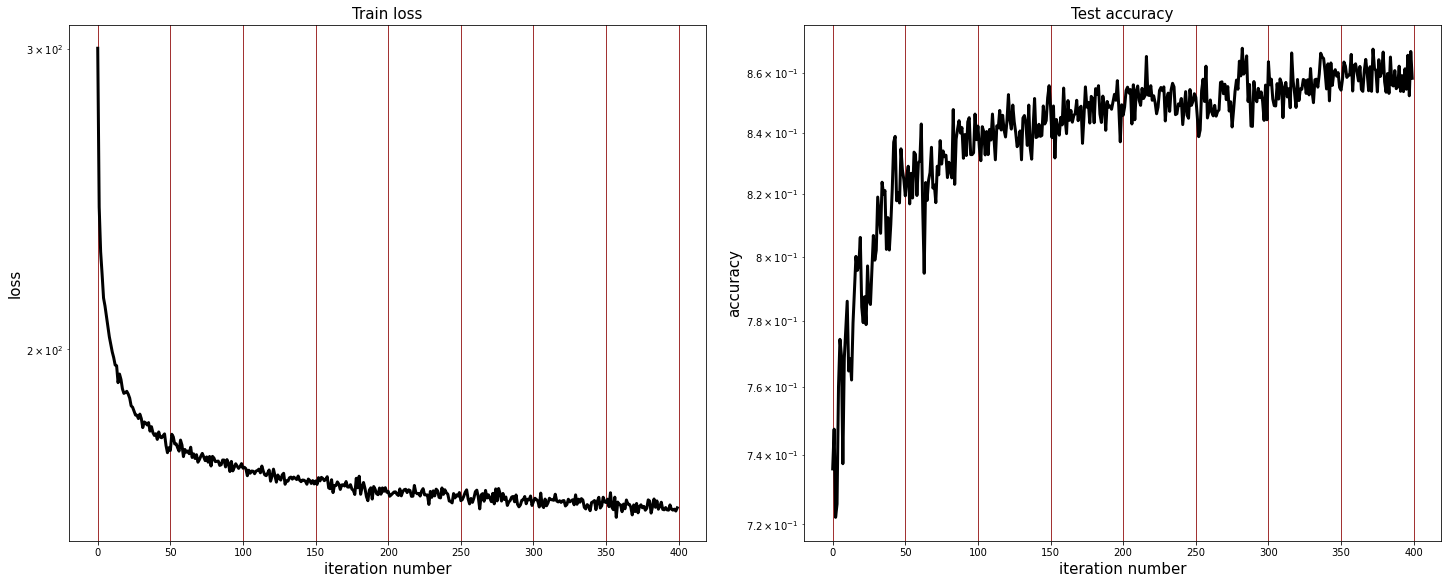

In [24]:
fg = plt.figure(figsize=(20, 8), constrained_layout=True, facecolor = "white")
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)

fig_ax_1 = fg.add_subplot(gs[0, 0], facecolor = "white")
fig_ax_1.semilogy(losses, 'black', linewidth=3)
fig_ax_1.set_xlabel("iteration number", fontsize=15)
fig_ax_1.set_ylabel("loss", fontsize=15)
fig_ax_1.set_title("Train loss", fontsize=15)
fig_ax_1.grid(color='darkred')

fig_ax_1 = fg.add_subplot(gs[0, 1], facecolor = "white")
fig_ax_1.semilogy(accuracies, 'black', linewidth=3)
fig_ax_1.set_xlabel("iteration number", fontsize=15)
fig_ax_1.set_ylabel("accuracy", fontsize=15)
fig_ax_1.set_title("Test accuracy", fontsize=15)
fig_ax_1.grid(color='darkred')

print("loss:", loss)
print("accuracy:", accuracy(model))

### Conclusions:
The overtraining problem is well fixed by the dropout technique. Also, do not make too large grids for such a simple task (not so much data and small input), it will encourage overfitting